In [1]:
import numpy as np
import imutils
import cv2

import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

%matplotlib inline

In [18]:
dir1 = 'car.jpg'
img1 = cv2.imread(dir1)

def display(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    imgplot = plt.imshow(img_rgb)

# Plate detection

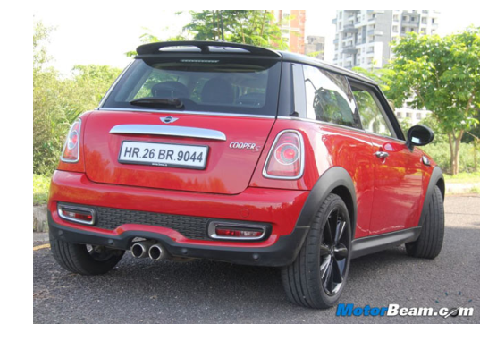

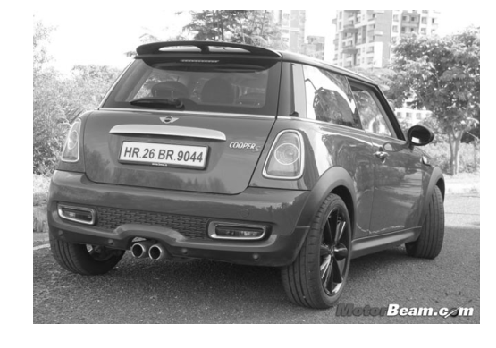

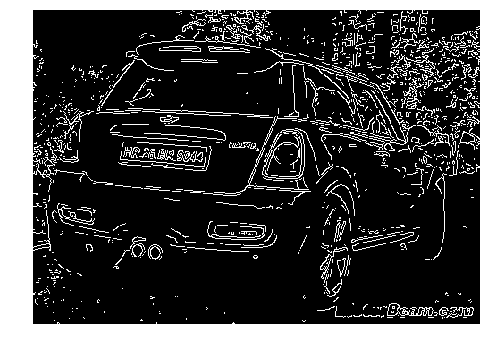

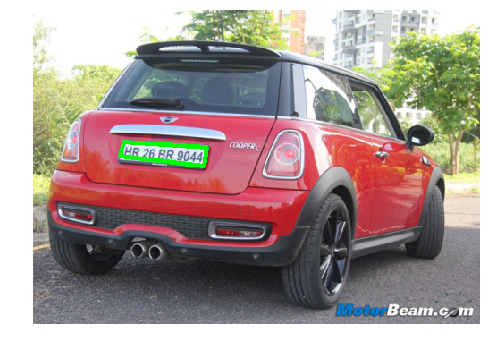

In [3]:
image = imutils.resize(img1, width=500)

# Display the original image
display(image)

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(gray)

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
# gray = cv2.bilateralFilter(gray, 11, 17, 17)
# display(gray)

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
display(edged)

# Find contours based on Edges
(cnts, new) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            break


# Drawing the selected contour on the original image
plate = cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
# cv2.imshow("Final Image With Number Plate Detected", image)
# cv2.waitKey(0)
display(plate)


# plate sepration

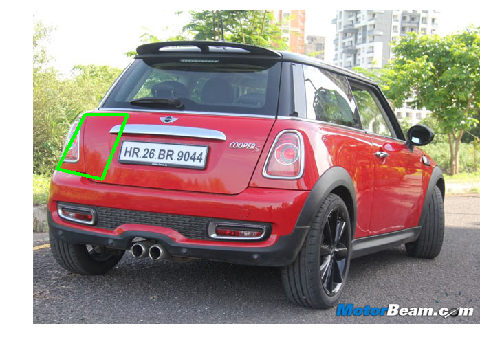

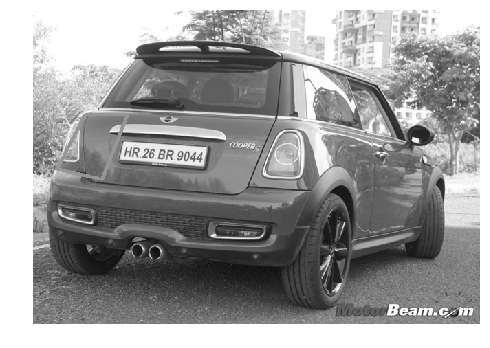

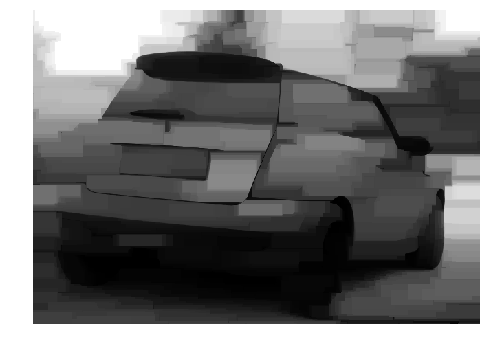

In [33]:
image = img1
display(image)

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display(gray)

# no need to remove the noise
# bilateral filter(removes noise while preserving edges)
# gray = cv2.bilateralFilter(gray, 11, 17, 17)
# display(gray)

# Histogram equalisation for better results
equal_histogram = cv2.equalizeHist(gray)

# Morphological opening with a rectangular structure element
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,2))                     # create the kernel
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)     # Morphological opening using the kernal created
display(morph_image)


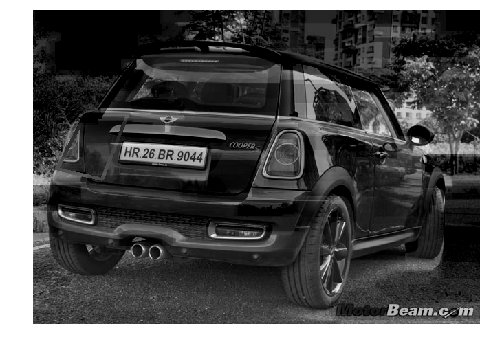

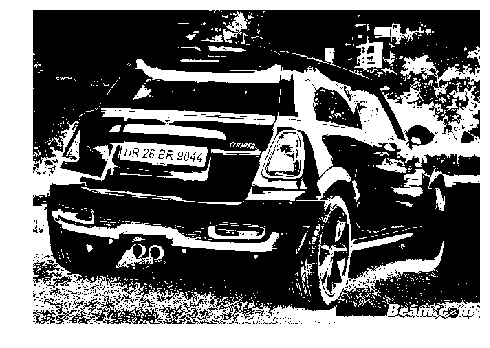

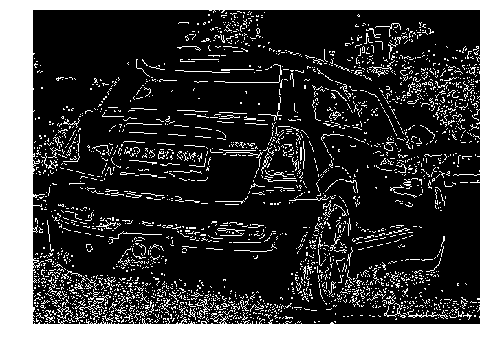

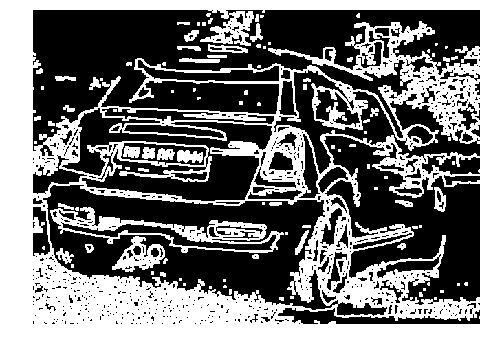

In [34]:
# time to make a mask

# enhance the rectangles
sub_morp_image = cv2.subtract(gray,morph_image)
display(sub_morp_image)

#thresholding 
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_OTSU)
display(thresh_image)

# Applying Canny Edge detection
canny_image = cv2.Canny(thresh_image,120,255)
canny_image = cv2.convertScaleAbs(canny_image)
display(canny_image)

# Dilation - to strengthen the edges
kernel = np.ones((3,3), np.uint8)                               # Create the kernel for dilation
dilated_image = cv2.dilate(canny_image,kernel,iterations=1)     # Carry out Dilation
display(dilated_image)



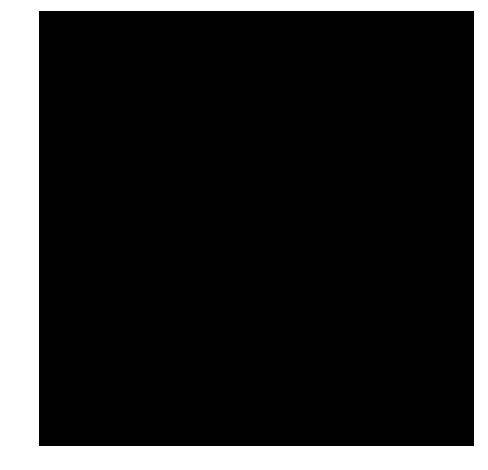

In [30]:
kernel = np.ones((3,3), np.uint8)
display(kernel)

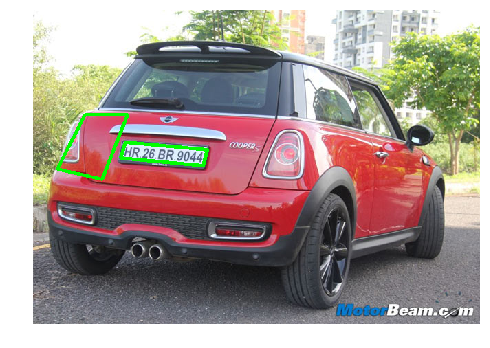

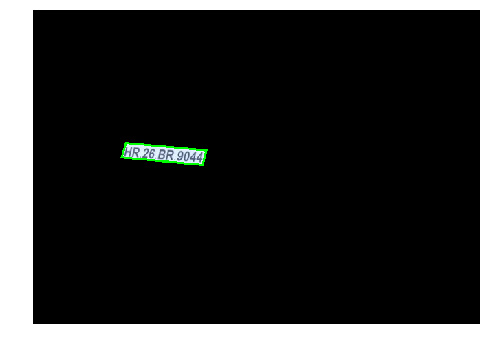

In [35]:
# Finding Contours in the image based on edges
contours, new = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort the contours based on area ,so that the number plate will be in top 10 contours
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:10]

NumberPlateCnt = None

# loop over the contours list
for c in contours:
     # approximate the contour
     peri = cv2.arcLength(c, True)
     approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # Approximating with 6% error
     # if our approximated contour has four points, then
     # we can assume that we have found our NumberPlate
     if len(approx) == 4:           # Select the contour with 4 corners
          NumberPlateCnt = approx   #assign to NumberPlateCnt when approximate contour found
          break                     # break the loop when Number Plate contour found/approximated

# Drawing the selected contour on the original image
final = cv2.drawContours(image, [NumberPlateCnt], -1, (0, 255, 0), 3)

display(final)

# SEPARATING OUT THE NUMBER PLATE FROM IMAGE:

# Masking the part other than the number plate
mask = np.zeros(gray.shape, np.uint8)                            # create an empty black image
new_image = cv2.drawContours(mask,[NumberPlateCnt],0,255,-1,)       # Draw the contour of number plate on the black image - This is our mask
new_image = cv2.bitwise_and(image,image,mask=mask)    
display(new_image)